# Time Series Tasks

## Regression

- ANN
- LSTM
- CNN
- CNN + LSTM

## Classification

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
if tf.config.list_logical_devices("GPU") : print("GPU detected.")
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.backend import sign

import math

2022-11-28 20:06:25.439179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 20:06:25.562830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 20:06:25.563033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 20:06:25.586443: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

GPU detected.


In [126]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['value']=scaler.fit_transform(df['value'].values.reshape(-1,1))
    return df

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

## FGSM
![fgsm](https://miro.medium.com/max/432/1*PAF7Lj2lcMw4kuRqBYhlYA.png)

## PGD
![pgd]()


In [177]:
def fgsm_attack(data, epsilon, loss):
    # Collect the element-wise sign of the data gradient
    data_gradient = np.gradient(loss)
    sign_data_gradient = sign(data_gradient[0])
    sign_data_gradient = np.reshape(sign_data_gradient, (1000, 23, 1))
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_data = data + epsilon*sign_data_gradient
    # Return the perturbed image
    return perturbed_data

def pgd_attack(X_test, y_test, model, iterations, alpha, epsilon):
    
    gen_img = tf.convert_to_tensor(X_test, dtype=tf.float32)
#     gen_img = gen_img + tf.random.uniform(gen_img.get_shape().as_list(), minval=-epsilon, maxval=epsilon, dtype=tf.dtypes.float32)
    gen_img = tf.clip_by_value(gen_img, X_test-epsilon, X_test+epsilon)
    x_temp = X_test

    for iters in range(iterations):
        imgv = tf.Variable(gen_img)
        with tf.GradientTape() as tape:
            tape.watch(imgv)
            predictions = model(imgv)
            loss = tf.keras.losses.MeanSquaredError()(y_test, predictions)
            grads = tape.gradient(loss,imgv)

        signed_grads = tf.sign(grads)
        gen_img = gen_img + (alpha*signed_grads)
        gen_img = tf.clip_by_value(gen_img, X_test-epsilon, X_test+epsilon)
        
    return gen_img

In [4]:
fpath='data/hourly-energy-consumption/AEP_hourly.csv'
df=pd.read_csv(fpath)
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.columns = ["value"]
display(df.head())

df_norm = normalize_data(df)
df_norm.shape

,value
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


(121273, 1)

In [5]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(0, len(stock)-seq_len, seq_len+1):
        X_train.append(stock.iloc[i: i+seq_len, 0])
        y_train.append(stock.iloc[i+seq_len, 0])
        
    #last 1000 days are going to be used in test
    X_test = X_train[4053:]             
    y_test = y_train[4053:]
    
    #first 4053 days are going to be used in training
    X_train = X_train[:4053]           
    y_train = y_train[:4053]
    
    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (4053, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

#create train, test data
seq_len = 23 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (4053, 23, 1)
y_train.shape =  (4053,)
X_test.shape =  (1000, 23, 1)
y_test.shape =  (1000,)


In [179]:
# build model
lstm_model = Sequential()
lstm_model.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()

lstm_model_2 = Sequential()
lstm_model_2.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1), return_sequences=True))
lstm_model_2.add(Dropout(0.15))
lstm_model_2.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1)))
lstm_model_2.add(Dense(1))

annModel = Sequential()
annModel.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
annModel.add(Dense(1))

models = {
    "lstm_model": lstm_model,
    "lstm_model_2": lstm_model_2,
#     "annModel": annModel
    }


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 23)                2300      
                                                                 
 dropout_2 (Dropout)         (None, 23)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 24        
                                                                 
Total params: 2,324
Trainable params: 2,324
Non-trainable params: 0
_________________________________________________________________


In [7]:
model = lstm_model_2
# train LSTM model
model.compile(optimizer="adam",loss="MSE")
model.fit(X_train, y_train, epochs=10)

Epoch 1/10


2022-11-28 20:06:29.832310: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600


127/127 [==============================] - 3s 5ms/step - loss: 0.0251
Epoch 2/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0120
Epoch 3/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 4/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0044
Epoch 5/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 6/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0032
Epoch 7/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0028
Epoch 8/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 9/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0021
Epoch 10/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0019


In [8]:
lstm_predictions = model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",round(lstm_score,2))

R^2 Score of LSTM model =  0.92


In [9]:
lstm_predictions = lstm_predictions.reshape((lstm_predictions.shape[0]))
print("RMSE :",round(math.sqrt(mean_squared_error(y_test, lstm_predictions))*100,2))
print("MAPE :",round(mape(y_test, lstm_predictions),2))

RMSE : 3.54
MAPE : 8.02


### Adversarial Attack (FGSM)

In [10]:
adversarial = fgsm_attack(X_test, 0.1, mean_squared_error(X_test, y_test))

In [11]:
adversarial_prediction = model.predict(adversarial)
adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, adversarial_prediction),2)
print("FGSM Adversarial R^2 : ", adversarial_score_r2)
print("FGSM Adversarial RMSE : ", adversarial_rmse)
print("FGSM Adversarial MAPE : ", adversarial_mape)

FGSM Adversarial R^2 :  0.49
FGSM Adversarial RMSE :  9.09
FGSM Adversarial MAPE :  48.13


### Results

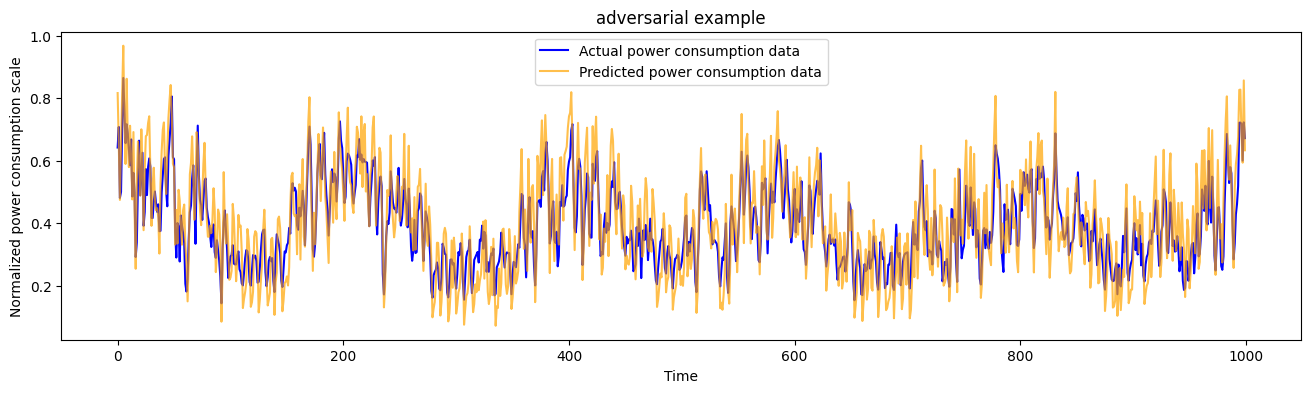

In [12]:
plot_predictions(y_test, adversarial_prediction, "adversarial example")

### Adversarial Attack (PGD)

In [157]:
# for alpha in [0.1,0.2,0.5,1,2,3,5,10,15]:
mapes = []
eps_list = [round(1*(math.pow(10,i/10)),3) for i in range(-30,1,2)]
eps_list = [0,0.000001, 0.001, 0.01]
for epsilon in eps_list:

    iterations = 10
    alpha = 0
#         epsilon = 5/100

    adversarial = pgd_attack(X_test, y_test, model, iterations, alpha, epsilon)

    adversarial_prediction = model.predict(adversarial)

    adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
    adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
    adversarial_mape = round(mape(y_test, adversarial_prediction),2)
    
    mapes.append(adversarial_mape)
#         print("PGD Adversarial R^2 : ", adversarial_score_r2)
#         print("PGD Adversarial RMSE : ", adversarial_rmse)
#         print("PGD Adversarial MAPE : ", adversarial_mape)

#     print("alpha :", round(alpha/1,2), " epsilon :", round(epsilon/1,2),"\t", adversarial_score_r2, adversarial_rmse, adversarial_mape)

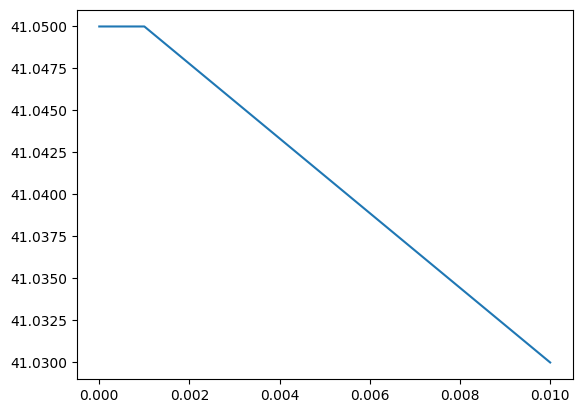

In [158]:
plt.plot(eps_list, mapes)
plt.show()

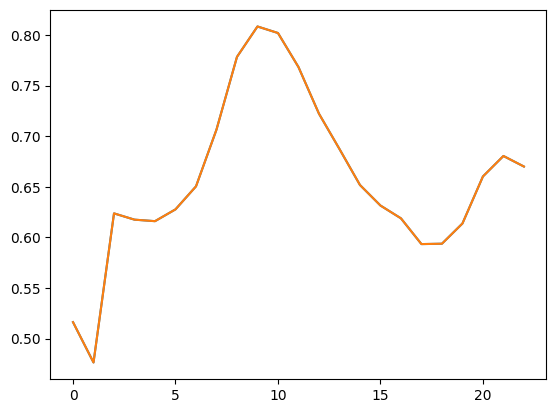

MAPE: 40.37 40.37


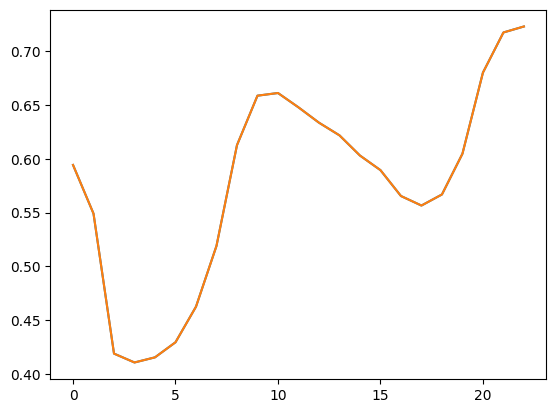

In [178]:
iterations = 0
alpha = 0
epsilon = 0
adversarial = pgd_attack(X_test, y_test, model, iterations, alpha, epsilon)

org_prediction = model.predict(X_test)
adversarial_prediction = model.predict(adversarial)

org_mape = round(mape(y_test, org_prediction),2)
adversarial_mape = round(mape(y_test, adversarial_prediction),2)
print("MAPE:",round(org_mape,2), round(adversarial_mape,2))

plt.plot(adversarial[1].numpy())
plt.plot(X_test[1])
plt.show()

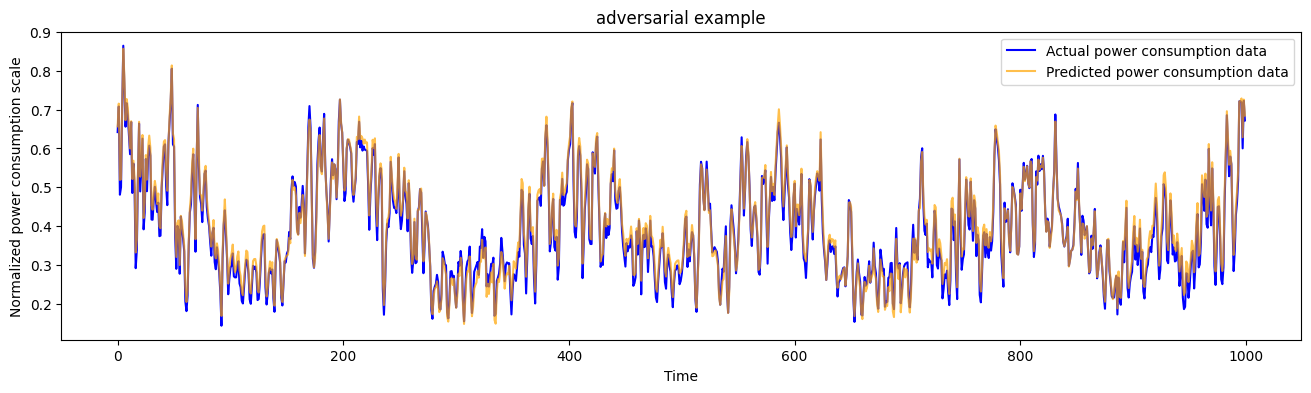

In [169]:
plot_predictions(y_test, adversarial_prediction, "adversarial example")

In [16]:
metric_df = {}
for metric in ["R2", "MAPE", "RMSE"]:
    metric_df[metric] = pd.DataFrame(index = models.keys(), columns = ["Vanilla", "FGSM", "PGD"])

Epoch 1/10
127/127 [==============================] - 3s 23ms/step - loss: 0.0047
Epoch 2/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0038
Epoch 3/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0034
Epoch 4/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0031
Epoch 5/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0028
Epoch 6/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0027
Epoch 7/10
127/127 [==============================] - 3s 23ms/step - loss: 0.0029
Epoch 8/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0027
Epoch 9/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0026
Epoch 10/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0025
R^2 : 0.95
RMSE : 2.76
MAPE : 6.68
FGSM Adversarial R^2 :  0.95
FGSM Adversarial RMSE :  2.76
FGSM Adversarial MAPE :  39.65


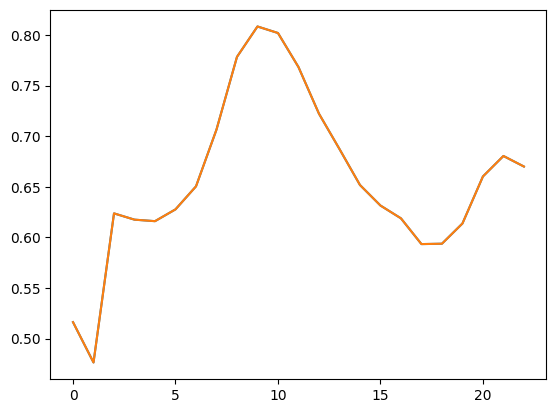

PGD Adversarial R^2 :  0.95
PGD Adversarial RMSE :  2.76
PGD Adversarial MAPE :  39.65
MAPE : 6.68
Epoch 1/10
127/127 [==============================] - 7s 49ms/step - loss: 0.0026
Epoch 2/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0024
Epoch 3/10
127/127 [==============================] - 6s 49ms/step - loss: 0.0022
Epoch 4/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0020
Epoch 5/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0020
Epoch 6/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0018
Epoch 7/10
127/127 [==============================] - 6s 49ms/step - loss: 0.0017
Epoch 8/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0016
Epoch 9/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0016
Epoch 10/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0015
R^2 : 0.96
RMSE : 2.54
MAPE : 5.88
FGSM Adversarial R^2 :  0.96
FGSM Adversarial

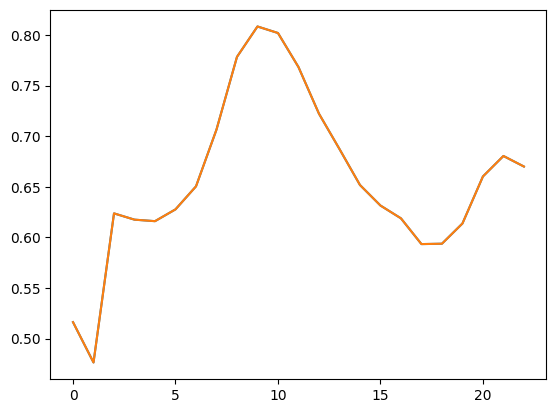

PGD Adversarial R^2 :  0.96
PGD Adversarial RMSE :  2.54
PGD Adversarial MAPE :  40.19
MAPE : 5.88


In [181]:
for item in models.items():
    
    model = item[1]
    #Train
    model.compile(optimizer="adam",loss="MSE")
    model.fit(X_train, y_train, epochs=10)
    
    preds = model.predict(X_test)
    R2_score = r2_score(y_test, preds)
    print("R^2 :",round(R2_score,2))
    preds = preds.reshape((preds.shape[0]))
    print("RMSE :",round(math.sqrt(mean_squared_error(y_test, preds))*100,2))
    print("MAPE :",round(mape(y_test, preds),2))
    
    metric_df["R2"].loc[item[0], "Vanilla"] = round(R2_score,2)
    metric_df["MAPE"].loc[item[0], "Vanilla"] = round(mape(y_test, preds),2)
    metric_df["RMSE"].loc[item[0], "Vanilla"] = round(math.sqrt(mean_squared_error(y_test, preds))*100,2)
    
    #FGSM
    adversarial_fgsm = fgsm_attack(X_test, 0.01, mean_squared_error(X_test, y_test))
    adversarial_prediction = model.predict(adversarial_fgsm)
    adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
    adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
    adversarial_mape = round(mape(y_test, adversarial_prediction),2)
    print("FGSM Adversarial R^2 : ", adversarial_score_r2)
    print("FGSM Adversarial RMSE : ", adversarial_rmse)
    print("FGSM Adversarial MAPE : ", adversarial_mape)
    
    metric_df["R2"].loc[item[0], "FGSM"] = adversarial_score_r2
    metric_df["MAPE"].loc[item[0], "FGSM"] = adversarial_mape
    metric_df["RMSE"].loc[item[0], "FGSM"] = adversarial_rmse
    
    #PGD
    adversarial_pgd = pgd_attack(X_test, y_test, model, 0,0,0)
    adversarial_prediction = model.predict(adversarial_pgd)
    adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
    adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
    adversarial_mape = round(mape(y_test, adversarial_prediction),2)
    print("PGD Adversarial R^2 : ", adversarial_score_r2)
    print("PGD Adversarial RMSE : ", adversarial_rmse)
    print("PGD Adversarial MAPE : ", adversarial_mape)
    print("MAPE :",round(mape(y_test, preds),2))
    
    metric_df["R2"].loc[item[0], "PGD"] = adversarial_score_r2
    metric_df["MAPE"].loc[item[0], "PGD"] = adversarial_mape
    metric_df["RMSE"].loc[item[0], "PGD"] = adversarial_rmse
    


In [182]:
for metric in metric_df.items():
    print(metric[0])
    display(metric[1])

R2


,Vanilla,FGSM,PGD
lstm_model,0.95,0.95,0.95
lstm_model_2,0.96,0.96,0.96


MAPE


,Vanilla,FGSM,PGD
lstm_model,6.68,39.65,39.65
lstm_model_2,5.88,40.19,40.19


RMSE


,Vanilla,FGSM,PGD
lstm_model,2.76,2.76,2.76
lstm_model_2,2.54,2.54,2.54


In [ ]:
# from foolbox import TensorFlowModel, accuracy, samples, Model
# from foolbox.attacks import LinfPGD

# fmodel: Model = TensorFlowModel(model, bounds=(0, 1))
# fmodel = fmodel.transform_bounds((0, 1))

# clean_acc = accuracy(fmodel, X_test, y_test)
# print(f"clean accuracy:  {clean_acc * 100:.1f} %")

# # apply the attack
# attack = LinfPGD()
# epsilons = [
#     0.0,
#     0.0002,
#     0.0005,
#     0.0008,
#     0.001,
#     0.0015,
#     0.002,
#     0.003,
#     0.01,
#     0.1,
#     0.3,
#     0.5,
#     1.0,
# ]
# raw_advs, clipped_advs, success = attack(fmodel, X_test, y_test, epsilons=epsilons)

In [19]:
from absl import app, flags
FLAGS = flags.FLAGS

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [122]:
x_pgd = projected_gradient_descent(lstm_model, X_test, 0.1, 0.01, 10, np.inf)
y_pred_pgd = lstm_model(x_pgd)
y_pred_pgd = y_pred_pgd.numpy()


adversarial_score_r2 = round(r2_score(y_test, y_pred_pgd),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, y_pred_pgd.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, y_pred_pgd),2)
print("PGD Adversarial R^2 : ", adversarial_score_r2)
print("PGD Adversarial RMSE : ", adversarial_rmse)
print("PGD Adversarial MAPE : ", adversarial_mape)

PGD Adversarial R^2 :  0.93
PGD Adversarial RMSE :  3.44
PGD Adversarial MAPE :  39.14


In [ ]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])